[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gladb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gladb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gladb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gladb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
D:\Program Files\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https:/

Original Content: drink alcohol reduc risk infect
Augmented Content: drinking alcohol reduc danger infect
Translated Content: Ku nwa byala swi hunguta khombo


Original Content: cdc updat covid number admit death record actual die covid
Augmented Content: cdc updat covid number admit end disc actual dice covid
Translated Content: Nhlayo ya vanhu lava pfumelaka leswaku a ku na lexi va faneleke va xi endla


Original Content: inject consum bleach disinfect kill viru
Augmented Content: inject consum bleach disinfect kill viru
Translated Content: Switsongwatsongwana leswi nga ni khombo swi dlaya switsongwatsongwana leswi nga ni khombo


Original Content: spray chlorin alcohol skin kill virus bodi
Augmented Content: spray chlorin alcohol skin kill virus bodi
Translated Content: Xitsongwatsongwana lexi vuriwaka chlorin xi dlaya xitsongwatsongwana lexi vuriwaka bodi


Original Content: older adult young peopl risk
Augmented Content: old adult youthful peopl danger
Translated Content: N'wana l

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
D:\Program Files\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1
Epoch 1 loss: 0.14691385597340825, accuracy: 0.9539121114683816
Epoch 2
Epoch 2 loss: 0.10415591214759609, accuracy: 0.9657020364415863
Epoch 3
Epoch 3 loss: 0.06579542595845385, accuracy: 0.9860664523043944


<Figure size 1200x600 with 0 Axes>

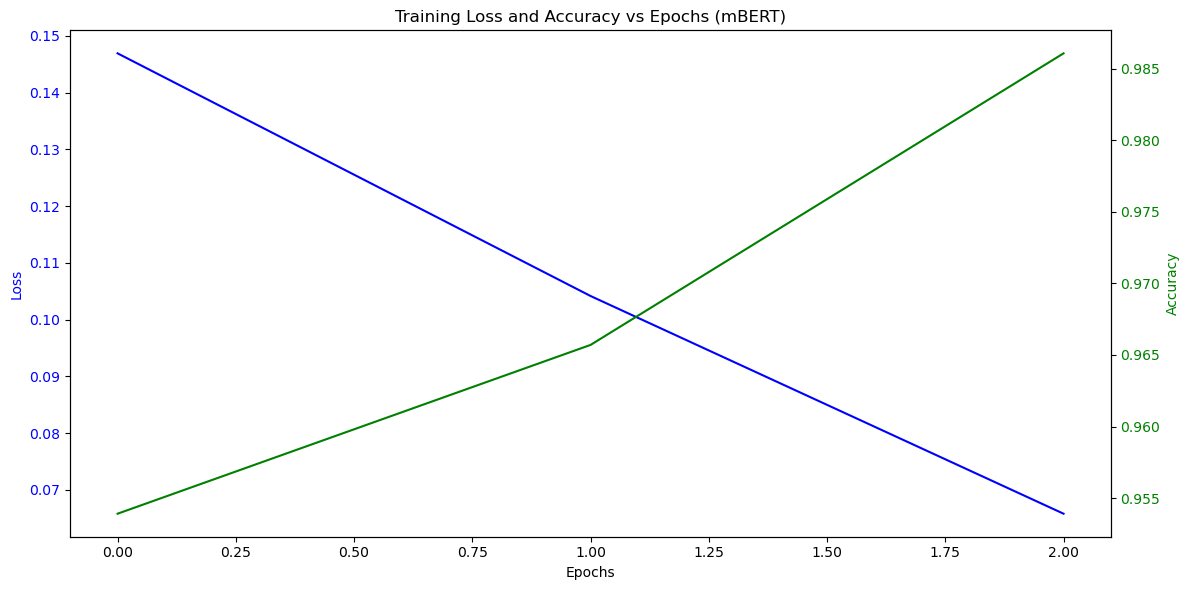

mBERT Accuracy: 0.9871794871794872
mBERT Precision: 0.8461538461538461
mBERT Recall: 0.9166666666666666
mBERT F1 Score: 0.88
Random Forest Accuracy: 0.9487179487179487
Random Forest Precision: 0.3333333333333333
Random Forest Recall: 0.2
Random Forest F1 Score: 0.25
           Model  Accuracy  Precision    Recall  F1 Score
0          mBERT  0.987179   0.846154  0.916667      0.88
1  Random Forest  0.948718   0.333333  0.200000      0.25


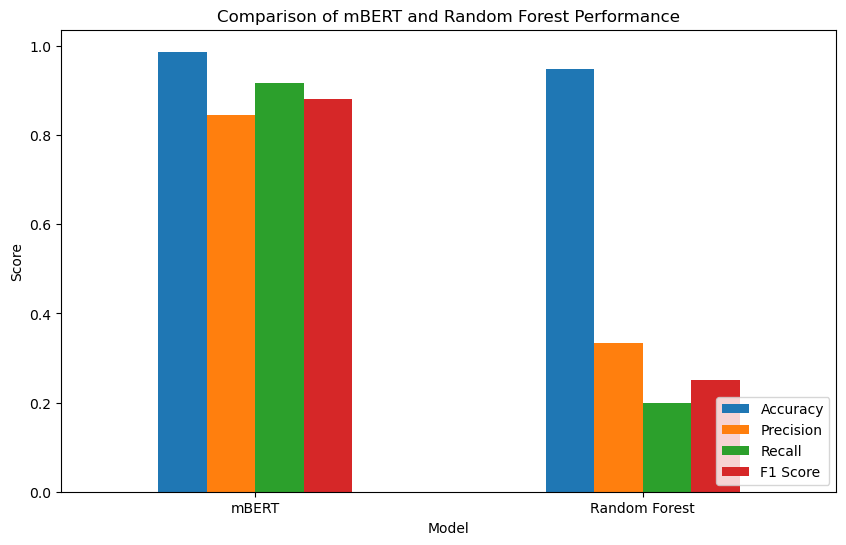

In [1]:
!pip install transformers torch sentencepiece nltk scikit-learn seaborn matplotlib
!pip install sacremoses

# Here are all the libraries that I'll be using for my research
import os
import pandas as pd
import re
import random
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import MarianMTModel, MarianTokenizer
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

# I am now initializing stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# I am loading my two datasets, one for real news and one for fake news
news_fake = pd.read_csv('NewsFakeCovid-19.csv')
news_real = pd.read_csv('NewsRealCovid-19.csv')

# Since I have two different datasets, I am now labeling them where 1 is Fake news and 0 is real news
news_fake['label'] = 1  
news_real['label'] = 0  

# Since I am having two different datasets, I am now making them one by combining them
news_data = pd.concat([news_fake, news_real], ignore_index=True)

# I am creating a function to clean the text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words and word not in string.punctuation]
    words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

# So here is my clean content column
news_data['clean_content'] = news_data['content'].apply(lambda x: clean_text(str(x)))

# Now here I am dropping rows where the 'clean_content' is empty or just whitespace
news_data = news_data[news_data['clean_content'].str.strip() != '']

# Now I am dropping duplicate rows
news_data.drop_duplicates(subset=['content'], keep='first', inplace=True)

# this is my function for removing repeated phrases
def remove_repeated_phrases(text):
    if isinstance(text, str): 
        sentences = text.split('. ')  
        unique_sentences = []
        for sentence in sentences:
            if sentence not in unique_sentences:
                unique_sentences.append(sentence)
        return '. '.join(unique_sentences)
    return text  

news_data['clean_content'] = news_data['clean_content'].apply(remove_repeated_phrases)
news_data = news_data[news_data['clean_content'].str.strip() != '']
news_data.reset_index(drop=True, inplace=True)

# Here is my enhanced synonym replacement for better accuracy with POS tagging and filtering
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def synonym_replacement(text, n=3):
    words = text.split()
    pos_tags = pos_tag(words)
    new_words = words.copy()
    random_word_list = list(set([word for word, pos in pos_tags if wordnet.synsets(word, get_wordnet_pos(pos))]))
    random.shuffle(random_word_list)

    num_replaced = 0
    max_attempts = 10
    attempts = 0

    while num_replaced < n and attempts < max_attempts:
        attempts += 1
        for random_word in random_word_list:
            word_pos = get_wordnet_pos(pos_tag([random_word])[0][1])
            synonyms = wordnet.synsets(random_word, pos=word_pos)
            synonyms = [lemma.name().replace('_', ' ') for syn in synonyms for lemma in syn.lemmas()
                        if lemma.name() != random_word and lemma.count() > 5]

            filtered_synonyms = [syn for syn in synonyms if syn not in new_words]

            if filtered_synonyms:
                synonym = random.choice(filtered_synonyms)
                new_words = [synonym if word == random_word else word for word in new_words]
                num_replaced += 1
            if num_replaced >= n:
                break

    return ' '.join(new_words)

# Now here I am applying synonym replacement and also translation
news_data['augmented_content'] = news_data['clean_content'].apply(lambda x: synonym_replacement(x, n=3))

# Here is my MarianMT model for translation to Xitsonga
model_name = 'Helsinki-NLP/opus-mt-en-ts'
translator_tokenizer = MarianTokenizer.from_pretrained(model_name)
translator_model = MarianMTModel.from_pretrained(model_name)

def translate_to_xitsonga(text):
    inputs = translator_tokenizer([text], return_tensors='pt', padding=True, truncation=True, max_length=512)
    translated_tokens = translator_model.generate(**inputs)
    translation = translator_tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
    return translation[0]

news_data['translated_content'] = news_data['augmented_content'].apply(lambda x: translate_to_xitsonga(x))

# So now I am printing the first 5 original, augmented, and translated texts
for i in range(5):
    print(f"Original Content: {news_data['clean_content'].iloc[i]}")
    print(f"Augmented Content: {news_data['augmented_content'].iloc[i]}")
    print(f"Translated Content: {news_data['translated_content'].iloc[i]}")
    print("\n")
    
# I am now saving the dataset with translated content for manual review and evaluation
news_data[['clean_content', 'augmented_content', 'translated_content']].to_csv('translated_news_data.csv', index=False)

# So this will save a CSV file with the original, augmented, and translated text content
print("Dataset with translated content saved as 'translated_news_data.csv' for manual evaluation.")

# So now here is my tokenizer and model setup for mBERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)

inputs = tokenizer(news_data['translated_content'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=512)
labels = torch.tensor(news_data['label'].tolist())

# Now I am creating TensorDataset and DataLoader
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=8)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=8)

# So here is my training setup for mBERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_dataloader) * 3  # 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_loss = []
train_accuracy = []

for epoch in range(3):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    print(f"Epoch {epoch + 1}")
    for batch in train_dataloader:
        b_input_ids, b_attention_mask, b_labels = [item.to(device) for item in batch]
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        logits = outputs.logits
        predictions = torch.argmax(logits, axis=1)
        correct_predictions += (predictions == b_labels).sum().item()
        total_predictions += len(b_labels)

    avg_loss = total_loss / len(train_dataloader)
    accuracy = correct_predictions / total_predictions
    train_loss.append(avg_loss)
    train_accuracy.append(accuracy)

    print(f"Epoch {epoch + 1} loss: {avg_loss}, accuracy: {accuracy}")

# Now here is my plot training loss and accuracy for mBERT
plt.figure(figsize=(12, 6))
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='blue')
ax1.plot(train_loss, label='Training Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy', color='green')
ax2.plot(train_accuracy, label='Training Accuracy', color='green')
ax2.tick_params(axis='y', labelcolor='green')
plt.title('Training Loss and Accuracy vs Epochs (mBERT)')
fig.tight_layout()  # Adjust layout to avoid overlap
plt.show()

# So now here is my evaluation for mBERT
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids, b_attention_mask, b_labels = [item.to(device) for item in batch]
        outputs = model(b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
        true_labels.extend(b_labels.cpu().numpy())

# Accuracy, precision, recall, F1 score for mBERT
accuracy_mbert = accuracy_score(true_labels, predictions)
precision_mbert, recall_mbert, f1_mbert, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

print(f"mBERT Accuracy: {accuracy_mbert}")
print(f"mBERT Precision: {precision_mbert}")
print(f"mBERT Recall: {recall_mbert}")
print(f"mBERT F1 Score: {f1_mbert}")

# So here is the Random Forest with TF-IDF as the second method
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(news_data['translated_content'])
y = news_data['label']

# Train-test split for TF-IDF with Random Forest
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_tfidf, y_train_tfidf)

# Now here is the predictions for Random Forest
y_pred_tfidf = rf_classifier.predict(X_test_tfidf)

# Here is the accuracy, precision, recall, F1 score for Random Forest
accuracy_rf = accuracy_score(y_test_tfidf, y_pred_tfidf)
precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(y_test_tfidf, y_pred_tfidf, average='binary')

print(f"Random Forest Accuracy: {accuracy_rf}")
print(f"Random Forest Precision: {precision_rf}")
print(f"Random Forest Recall: {recall_rf}")
print(f"Random Forest F1 Score: {f1_rf}")

# Now here I am comparing both models
results = pd.DataFrame({
    'Model': ['mBERT', 'Random Forest'],
    'Accuracy': [accuracy_mbert, accuracy_rf],
    'Precision': [precision_mbert, precision_rf],
    'Recall': [recall_mbert, recall_rf],
    'F1 Score': [f1_mbert, f1_rf]
})

print(results)

# Here now I am doing the visualization of performance comparison
results.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of mBERT and Random Forest Performance')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()
